In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../CSR2D/')

import csr2d.core2

# 3D CSR Potentials

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
#sigma_z = 40e-6
#sigma_x = 134e-6 
#rho = 1538.
#gamma = 58708.

sigma_z = 10e-6
sigma_x = 10e-6 
rho = 1.
gamma = 500.


beta = np.sqrt(1 - 1 / gamma ** 2)
beta2 = 1-1/gamma**2


# alpha

For convenience we will use the notatation

$\xi \rightarrow z$

$\chi \rightarrow x$

$\zeta \rightarrow y$

Then 

$z = \alpha - \frac{\beta}{2}\sqrt{x^2+y^2+4(1+x)\sin^2\alpha}$

In [5]:
from csr3d.core import alpha_exact, alpha, old_alpha, alpha_where_z_equals_zero

In [6]:
xmax = 1/gamma**2
xmin = -xmax
xptp = xmax-xmin

ymax = 1/gamma**2
ymin = -ymax
yptp = ymax-ymin

zmax = 1/gamma**2
zmin = -zmax
zptp = zmax-zmin

fac = 4
nx = int(32*fac)
ny = int(16*fac)
nz = int(64*fac)

dx = xptp/(nx-1)
dy = yptp/(ny-1)
dz = zptp/(nz-1)

xvec = np.linspace(xmin, xmax, nx)
yvec = np.linspace(ymin, ymax, ny)
zvec = np.linspace(zmin, zmax, nz)

X, Y, Z = np.meshgrid( xvec, yvec, zvec, indexing='ij')

xmax, ymax, zmax

(4e-06, 4e-06, 4e-06)

In [7]:
%%timeit
old_alpha(X, Y, Z, beta)

461 ms ± 25.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
alpha(X, Y, Z, beta)

143 ms ± 4.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
# This will be slow
A0 = alpha_exact(X, Y, Z, beta)

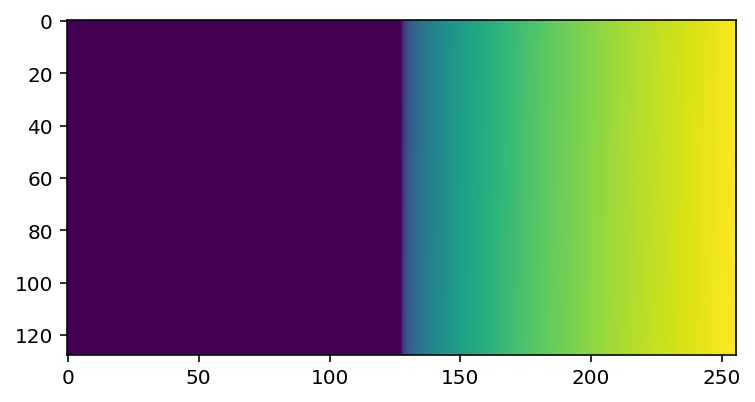

In [10]:
plt.imshow(A0[:,1,:])

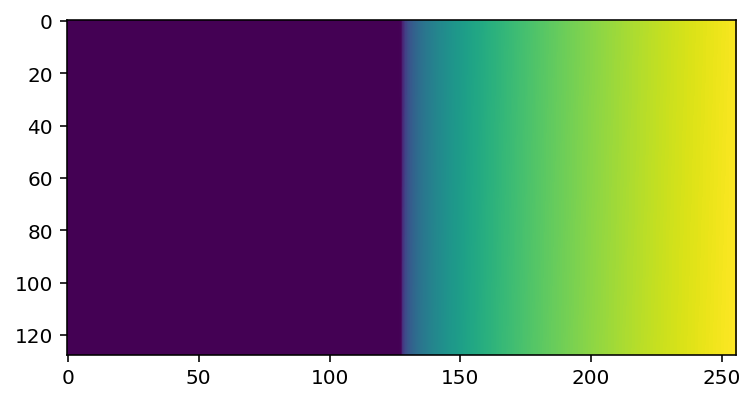

In [11]:
A1 = alpha(X, Y, Z, beta)
plt.imshow(A1[:,1,:])

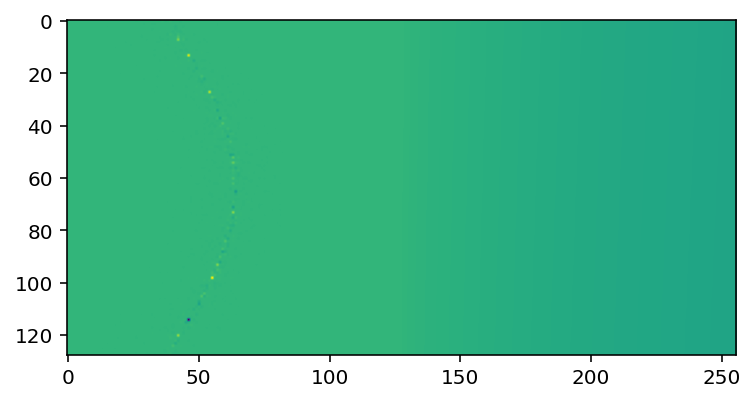

In [12]:
err = (A1-A0)/A0
np.abs(err).max()
plt.imshow(err[:,0,:])

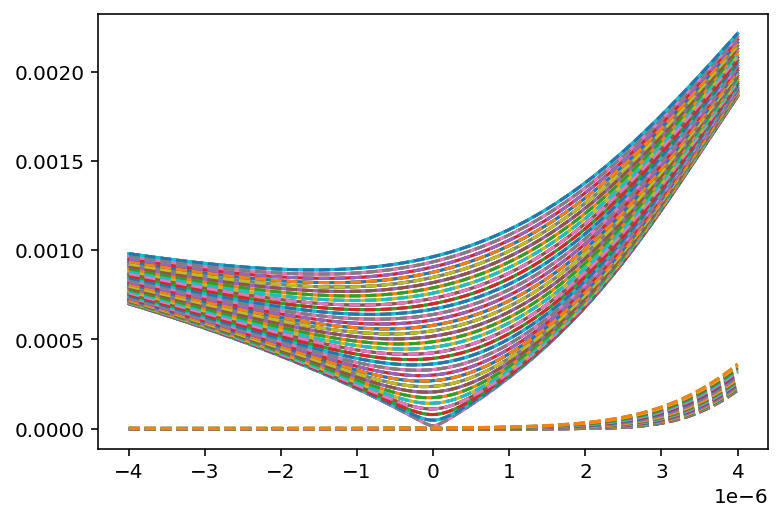

In [13]:
for y0 in yvec:
    a0 =  alpha_exact(xvec, y0, 0, beta2)
    a1 = alpha_where_z_equals_zero(xvec, y0, beta2)
    err = a0-a1
    plt.plot(xvec, a0)
    plt.plot(xvec, a1, linestyle='--')
    plt.plot(xvec, err*1e6, linestyle='--')

# psi_s

In [14]:
from csr3d.core import psi_s, old_psi_s

In [15]:
%%timeit
old_psi_s(X, Y, Z, beta)

555 ms ± 9.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
psi_s(X, Y, Z, beta)

200 ms ± 990 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
psi_s(0,0,0, beta)

0.0

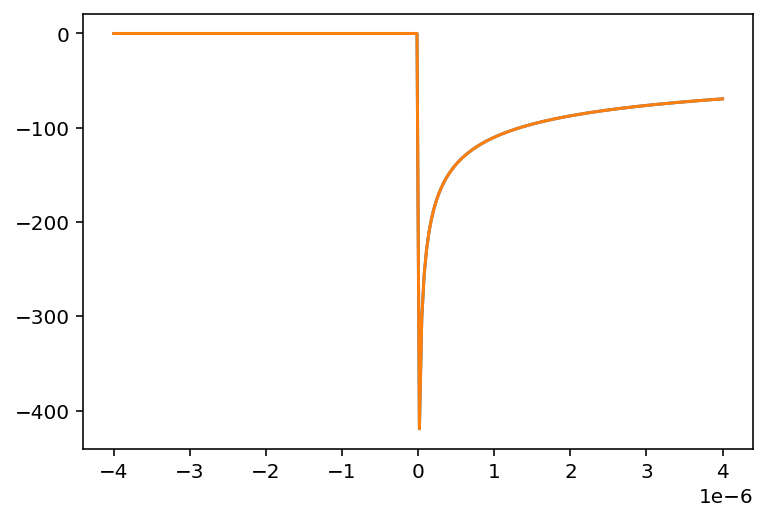

In [18]:
plt.plot(zvec, old_psi_s(0, 0, zvec, beta))
plt.plot(zvec, psi_s(0, 0, zvec, beta))

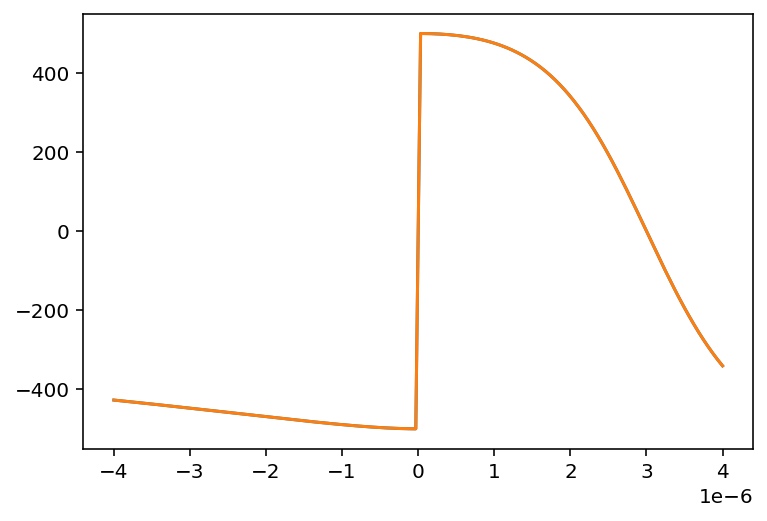

In [19]:
plt.plot(xvec, old_psi_s(xvec, 0, 0, beta))
plt.plot(xvec, psi_s(xvec, 0, 0, beta))

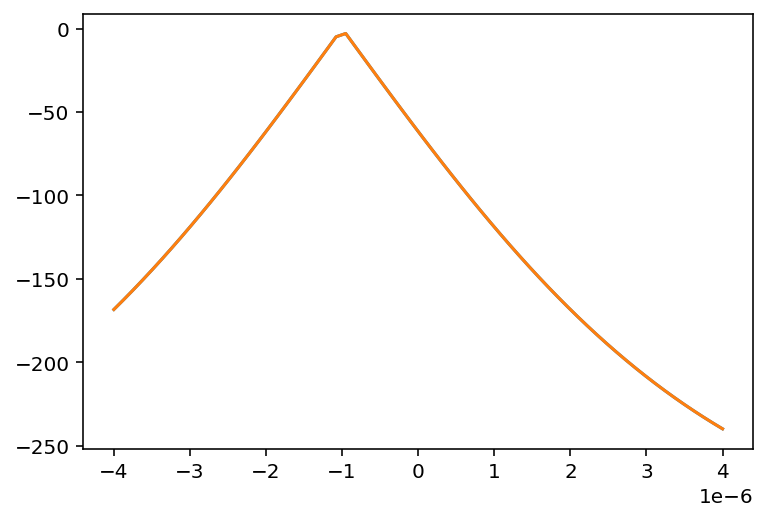

In [20]:
plt.plot(yvec, old_psi_s(0, yvec+1e-6, 0, beta))
plt.plot(yvec, psi_s(0, yvec+1e-6, 0, beta))

In [21]:
psi_s(0,1e-6,1e-6, beta)

-110.04697293067511

# psi_s mesh

In [22]:
from csr3d.wake import green_mesh

In [23]:
%%time
G = green_mesh((nx, ny, nz), (dx, dy, dz), rho=rho, beta=beta, component='s')

CPU times: user 1.82 s, sys: 191 ms, total: 2.01 s
Wall time: 2.03 s


In [24]:
%%time
Gs = green_mesh((nx, ny, nz), (dx, dy, dz/100), rho=rho, beta=beta, component='s')

CPU times: user 1.77 s, sys: 73.5 ms, total: 1.84 s
Wall time: 1.85 s


Text(0.5, 1.0, '$\\psi_s$')

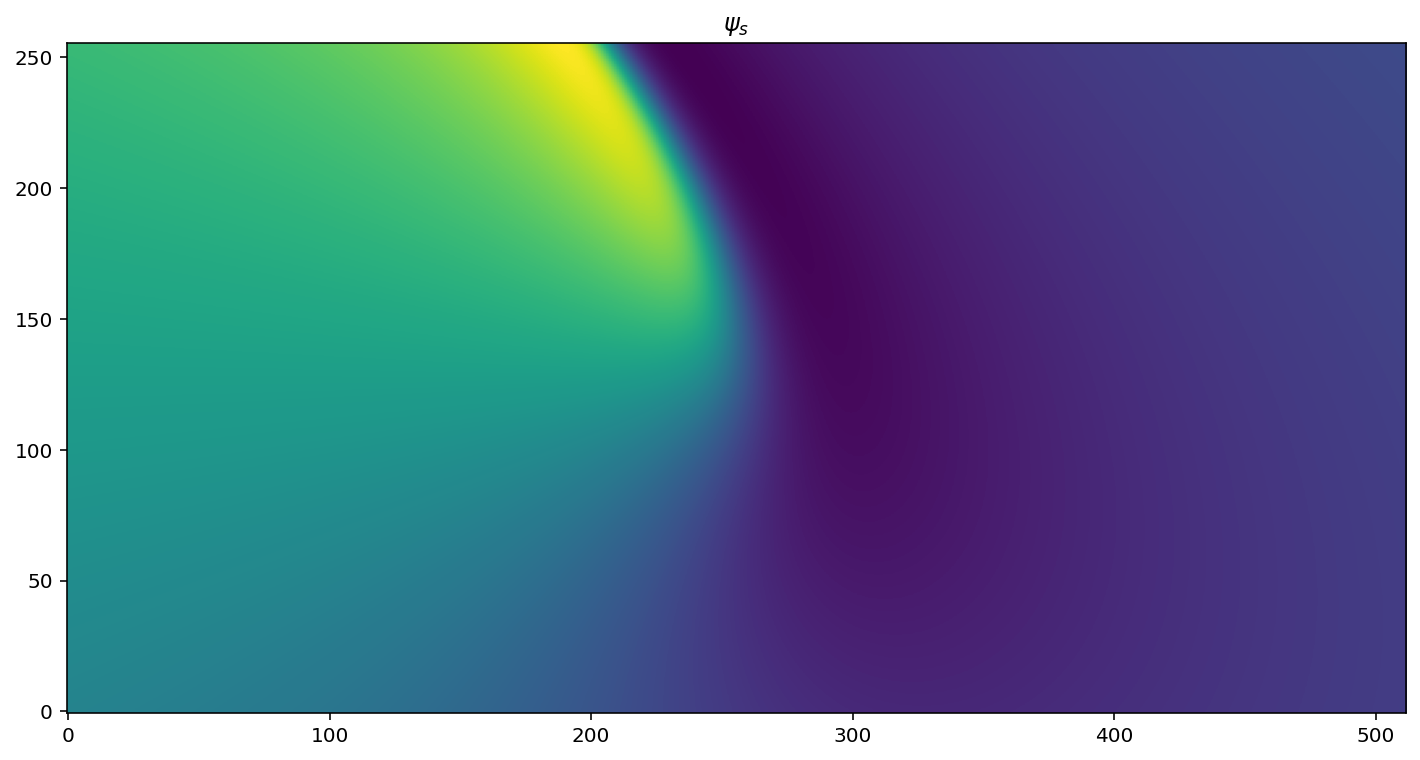

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(Gs[:,ny//2,:], origin='lower', aspect='equal')
ax.set_title(r'$\psi_s$')

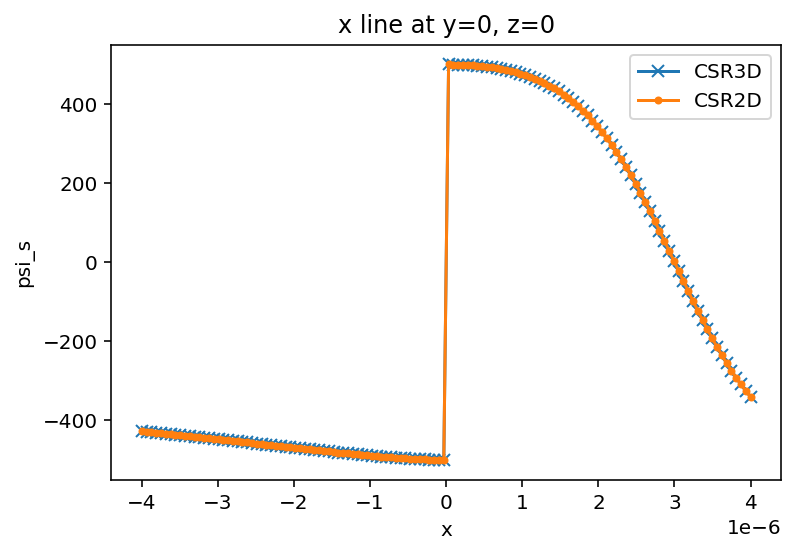

In [26]:
# x line
fig, ax = plt.subplots()
ax.plot(xvec, psi_s(xvec,0,0,beta), label='CSR3D', marker='x')
ax.plot(xvec, csr2d.core2.psi_s(0, xvec,beta), marker='.', label='CSR2D')
ax.set_title('x line at y=0, z=0')
ax.set_ylabel('psi_s')
ax.set_xlabel('x')
ax.legend()

Text(0.5, 0, 'y')

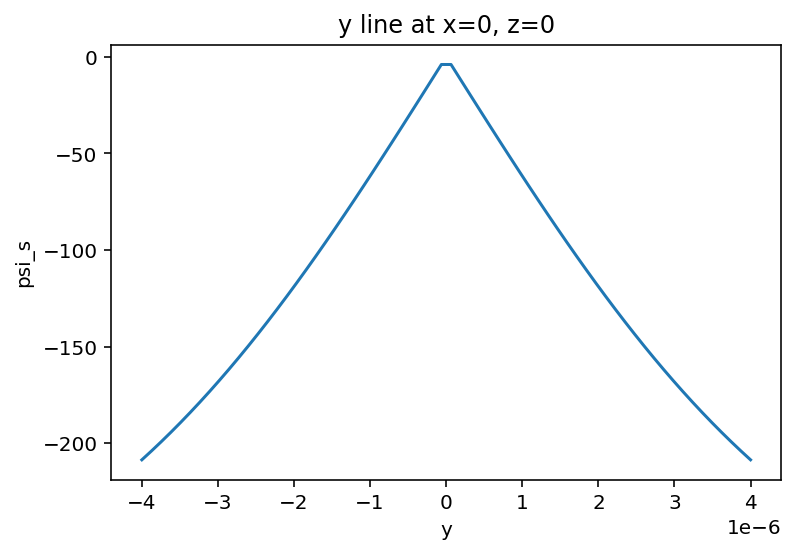

In [27]:
# y line
fig, ax = plt.subplots()
ax.plot(yvec, psi_s(0,yvec,0,beta))
ax.set_title('y line at x=0, z=0')
ax.set_ylabel('psi_s')
ax.set_xlabel('y')
#ax.legend()

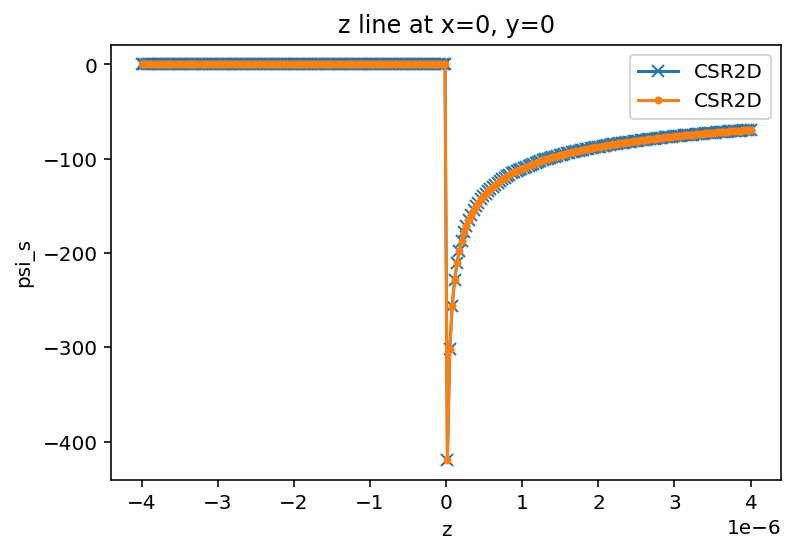

In [28]:
# z line
fig, ax = plt.subplots()
ax.plot(zvec, psi_s(0,0,zvec,beta), marker='x', label='CSR2D')
ax.plot(zvec, csr2d.core2.psi_s(zvec, 0,beta), marker='.', label='CSR2D')
ax.set_title('z line at x=0, y=0')
ax.set_ylabel('psi_s')
ax.set_xlabel('z')
ax.legend()

# psi_x

In [29]:
from csr3d.wake import green_mesh
from csr3d.core import psi_x, psi_x0, old_psi_x

# Compare with CSR2D at y=0
import csr2d.core2 

In [30]:
%%timeit
old_psi_x(X, Y, Z, beta)

1.24 s ± 55.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%%timeit
psi_x(X, Y, Z, beta)

699 ms ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%%timeit
psi_x0(X, Y, Z, beta, dx, dy, dz)

677 ms ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%%time
Gx = green_mesh((nx, ny, nz), (dx, dy, dz), rho=rho, beta=beta, component='x')
#X2, Y2, Z2 = tuple(meshes)

CPU times: user 5.87 s, sys: 197 ms, total: 6.07 s
Wall time: 6.1 s


Text(0, 0.5, 'x index')

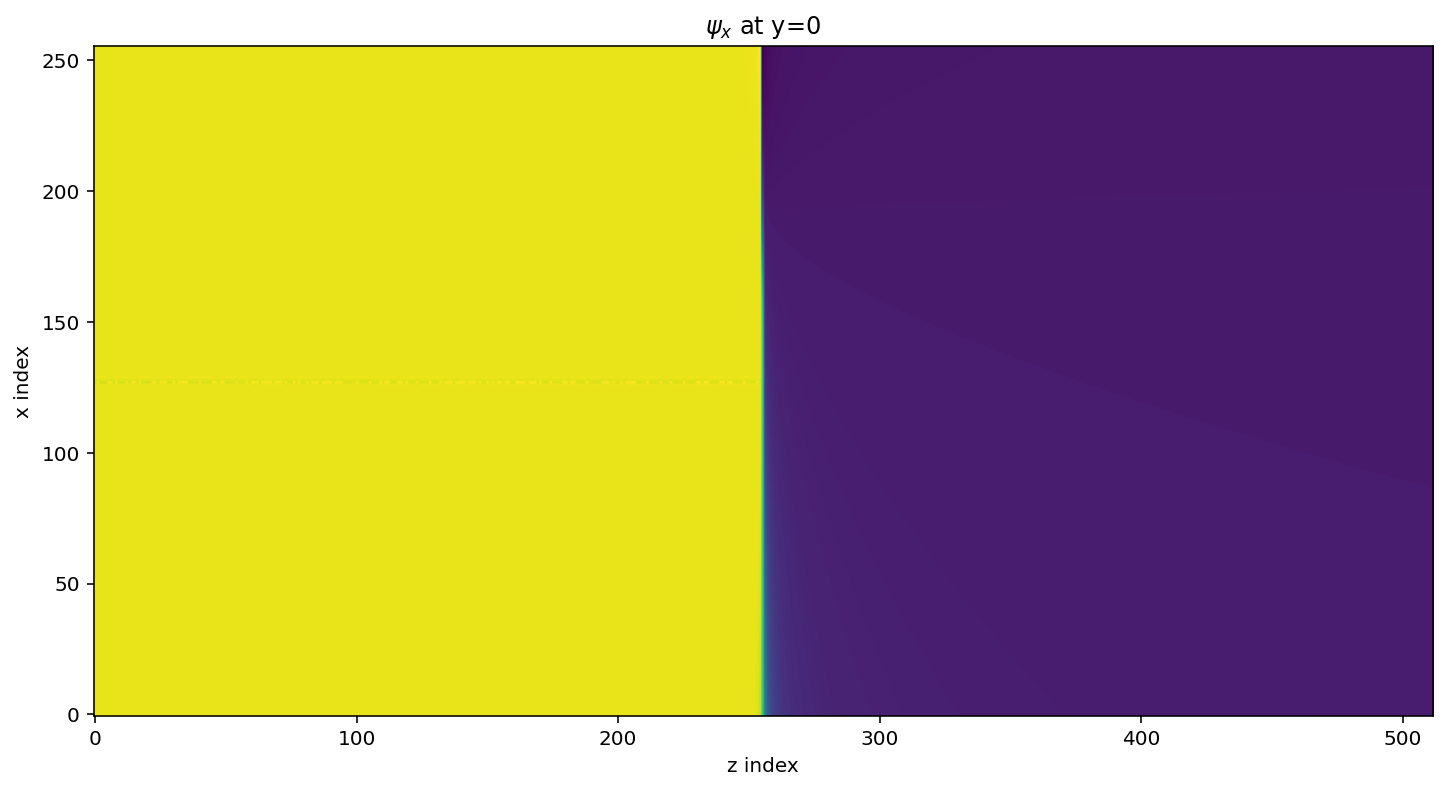

In [34]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(Gx[:,ny-1,:], origin='lower', aspect='equal')
ax.set_title(r'$\psi_x$ at y=0')
ax.set_xlabel('z index')
ax.set_ylabel('x index')

Text(0, 0.5, 'y index')

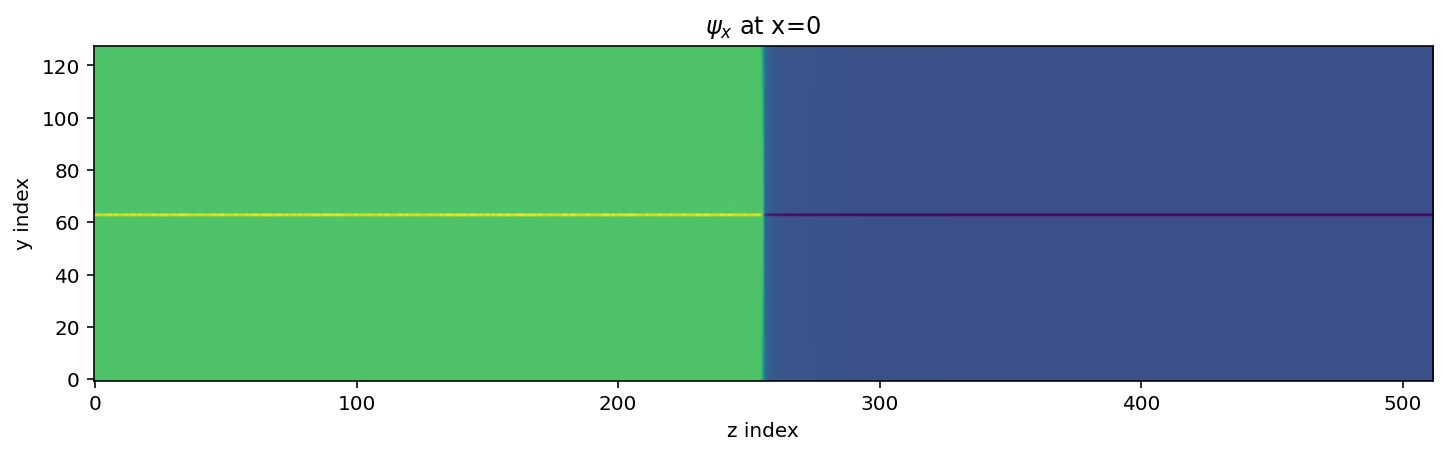

In [35]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(Gx[nx-1,:,:], origin='lower', aspect='equal')
ax.set_title(r'$\psi_x$ at x=0')
ax.set_xlabel('z index')
ax.set_ylabel('y index')

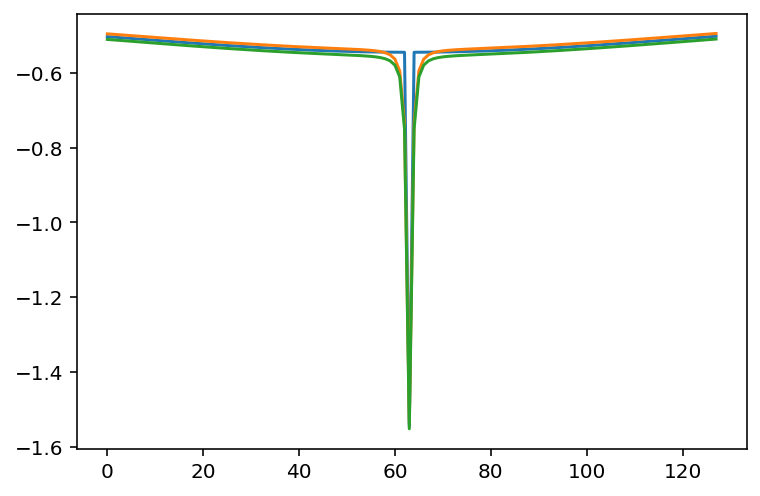

In [36]:
plt.plot(Gx[nx-1,:,nz])
plt.plot(Gx[nx-1-1,:,nz])

plt.plot(Gx[nx-1+1,:,nz])

Text(0, 0.5, 'y index')

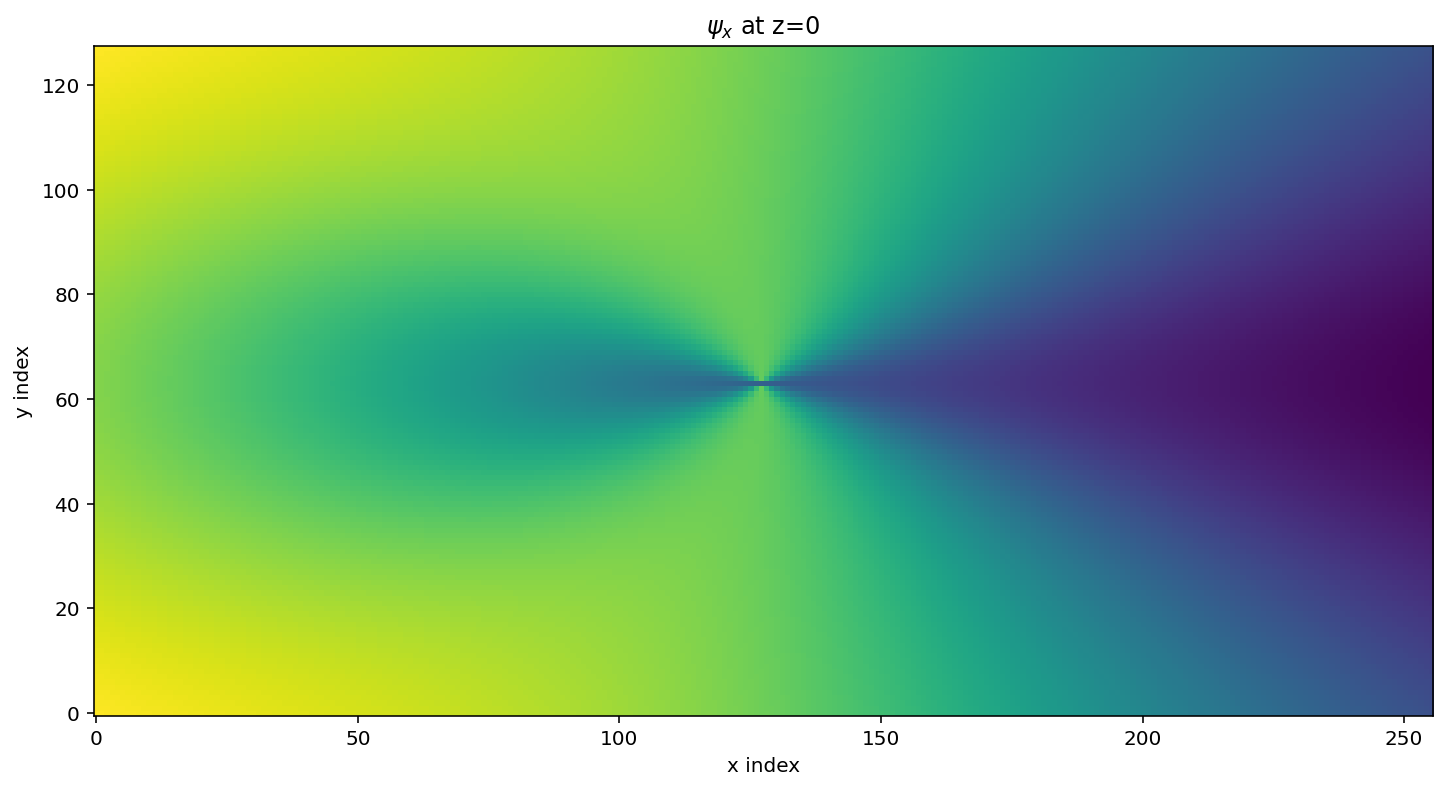

In [37]:
M = Gx[:,:,nz].T

fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(M, origin='lower', aspect='equal')
ax.set_title(r'$\psi_x$ at z=0')
ax.set_xlabel('x index')
ax.set_ylabel('y index')

In [38]:
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure(figsize=(20, 20))
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X2[:,:,nz], Y2[:,:,nz], M.T, alpha=0.7)#, facecolors=colors)
#ax.view_init(20,10)
#ax.set_xlabel('x (m)')
#ax.set_ylabel('y (m)')

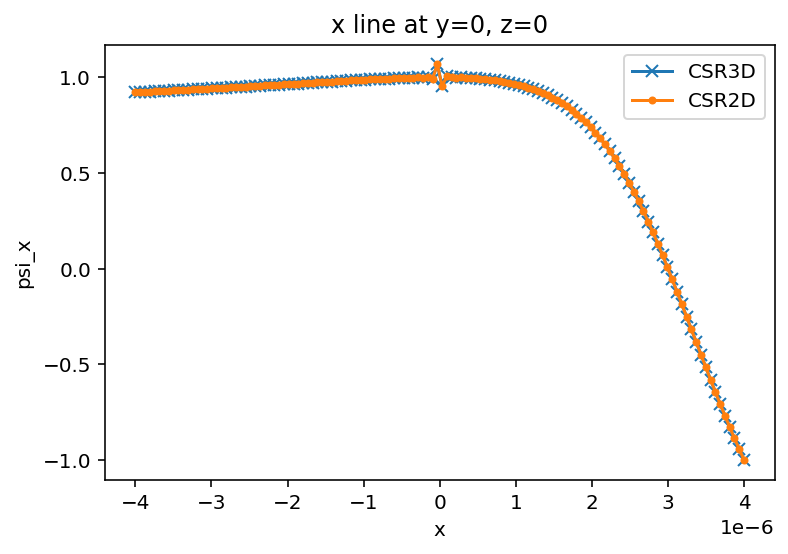

In [39]:
# x line
fig, ax = plt.subplots()
ax.plot(xvec, psi_x(xvec,0,0,beta), label='CSR3D', marker='x')
ax.plot(xvec, csr2d.core2.psi_x(0, xvec,beta), marker='.', label='CSR2D')
ax.set_title('x line at y=0, z=0')
ax.set_ylabel('psi_x')
ax.set_xlabel('x')
ax.legend()

Text(0.5, 0, 'y')

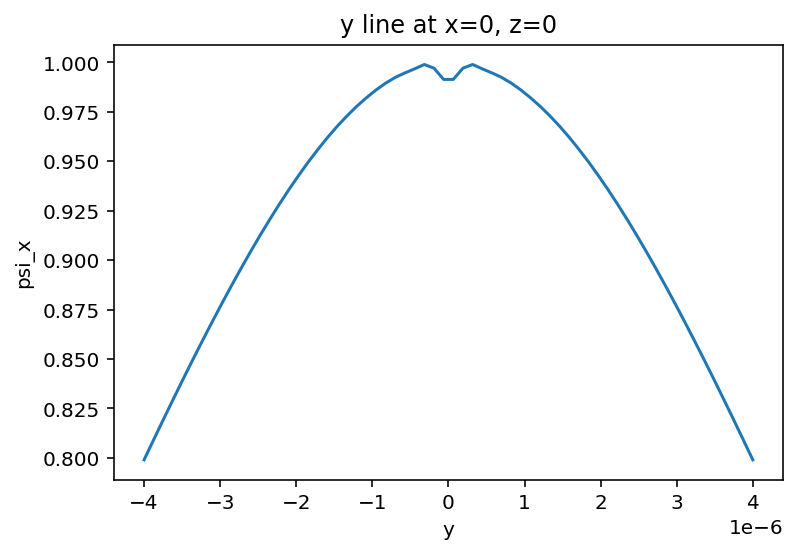

In [40]:
# y line
fig, ax = plt.subplots()
ax.plot(yvec, psi_x(0,yvec,0,beta))
ax.set_title('y line at x=0, z=0')
ax.set_ylabel('psi_x')
ax.set_xlabel('y')
#ax.legend()

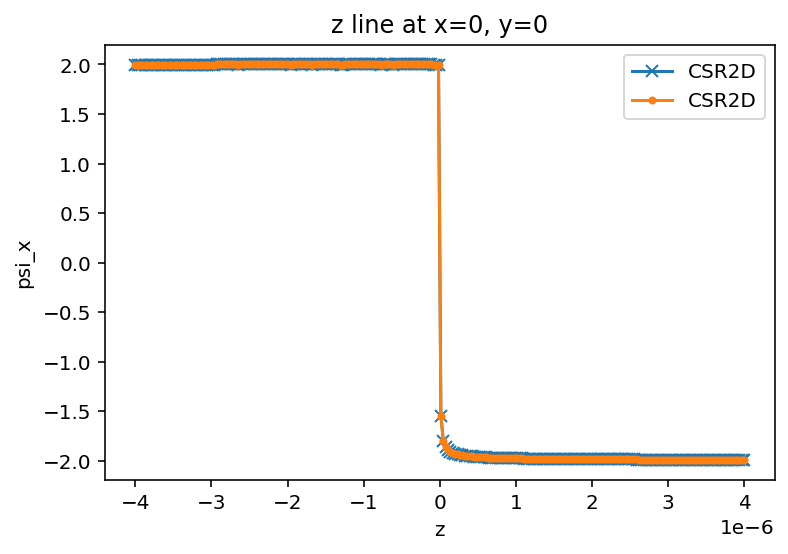

In [41]:
# z line
fig, ax = plt.subplots()
ax.plot(zvec, psi_x0(0,0,zvec,beta,1e-6, 1e-6, 1e-6), marker='x', label='CSR2D')
ax.plot(zvec, csr2d.core2.psi_x0(zvec, 0,beta, 1e-6), marker='.', label='CSR2D')
ax.set_title('z line at x=0, y=0')
ax.set_ylabel('psi_x')
ax.set_xlabel('z')
ax.legend()

# psi_y

In [42]:
from csr3d.core import psi_y, psi_y0, old_psi_y

In [43]:
%%timeit
R1 = old_psi_y(X, Y, Z, beta)

1.23 s ± 30.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%%timeit
R2 = psi_y(X, Y, Z, beta)

665 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%%timeit
R2 = psi_y0(X, Y, Z, beta, dx, dy, dz)

684 ms ± 25.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%%time
Gy = green_mesh((nx, ny, nz), (dx/10, dy/10, dz/100), rho=rho, beta=beta, component='y')
#X2, Y2, Z2 = tuple(meshes)

CPU times: user 6.3 s, sys: 208 ms, total: 6.51 s
Wall time: 6.59 s


Text(0, 0.5, 'x index')

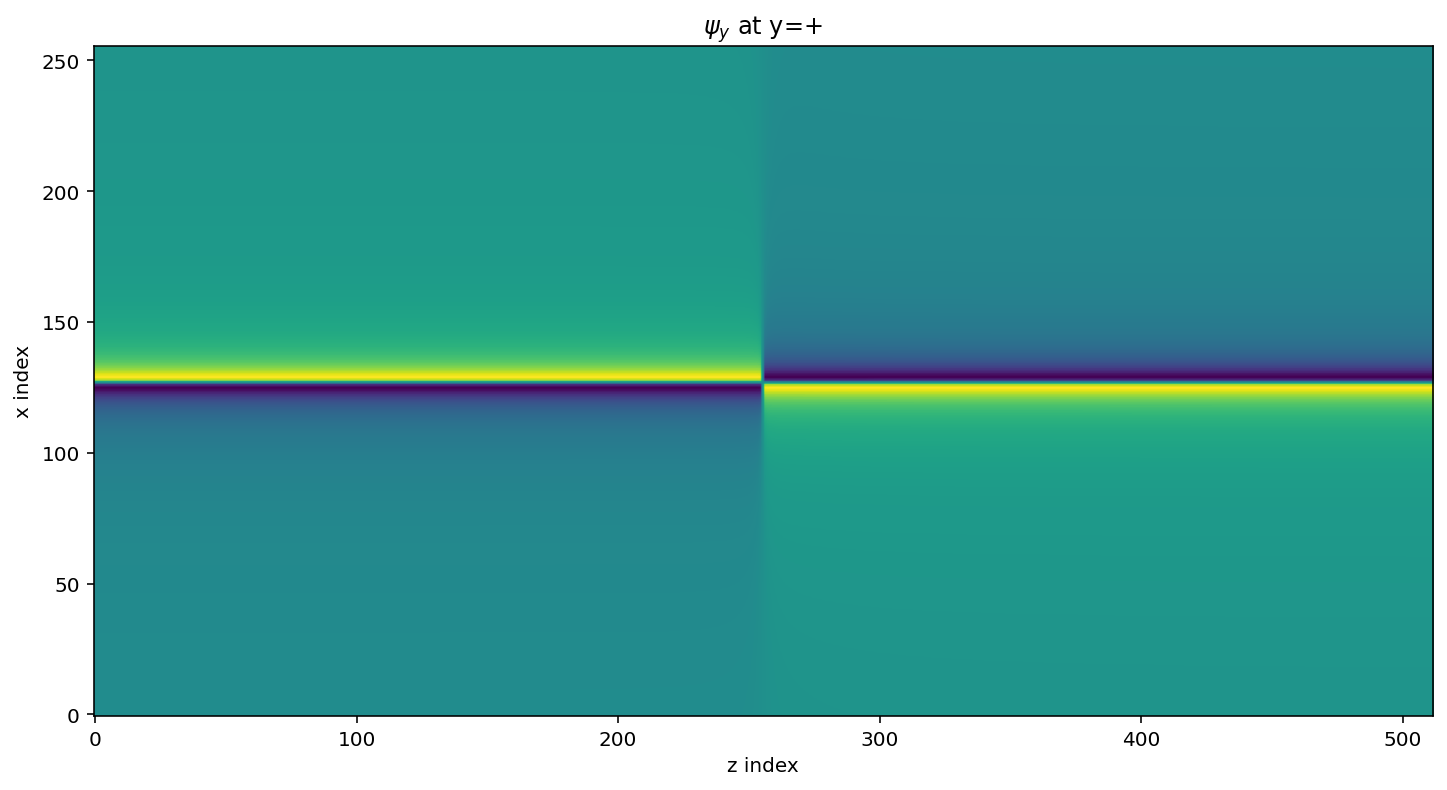

In [47]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(Gy[:,ny-1 +1,:], origin='lower', aspect='equal')
ax.set_title(r'$\psi_y$ at y=+')
ax.set_xlabel('z index')
ax.set_ylabel('x index')

Text(0, 0.5, 'y index')

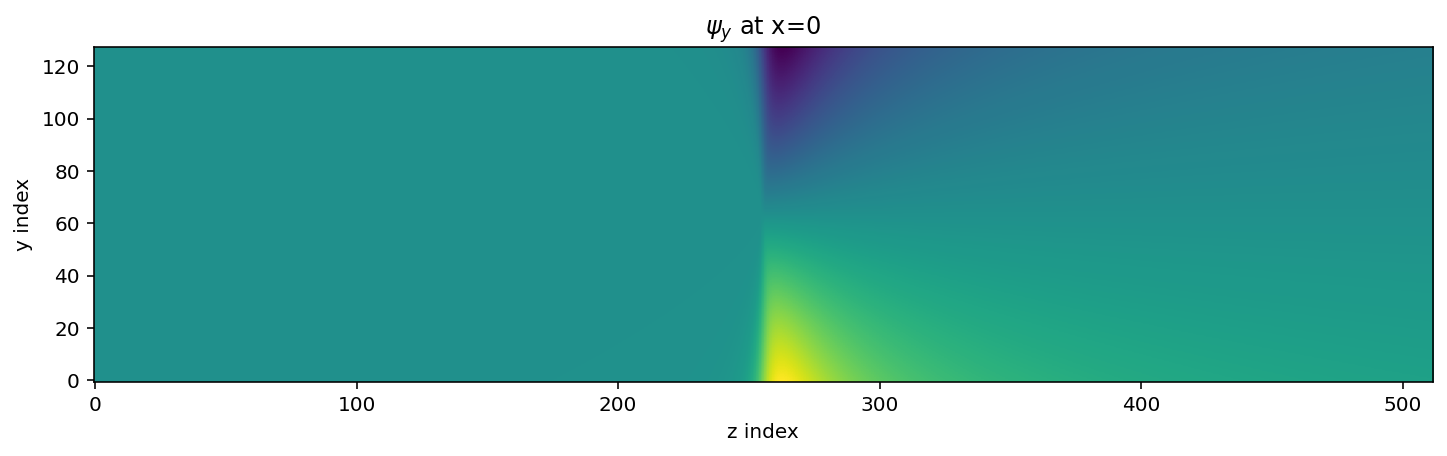

In [48]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(Gy[nx-1,:,:], origin='lower', aspect='equal')
ax.set_title(r'$\psi_y$ at x=0')
ax.set_xlabel('z index')
ax.set_ylabel('y index')

Text(0, 0.5, 'y index')

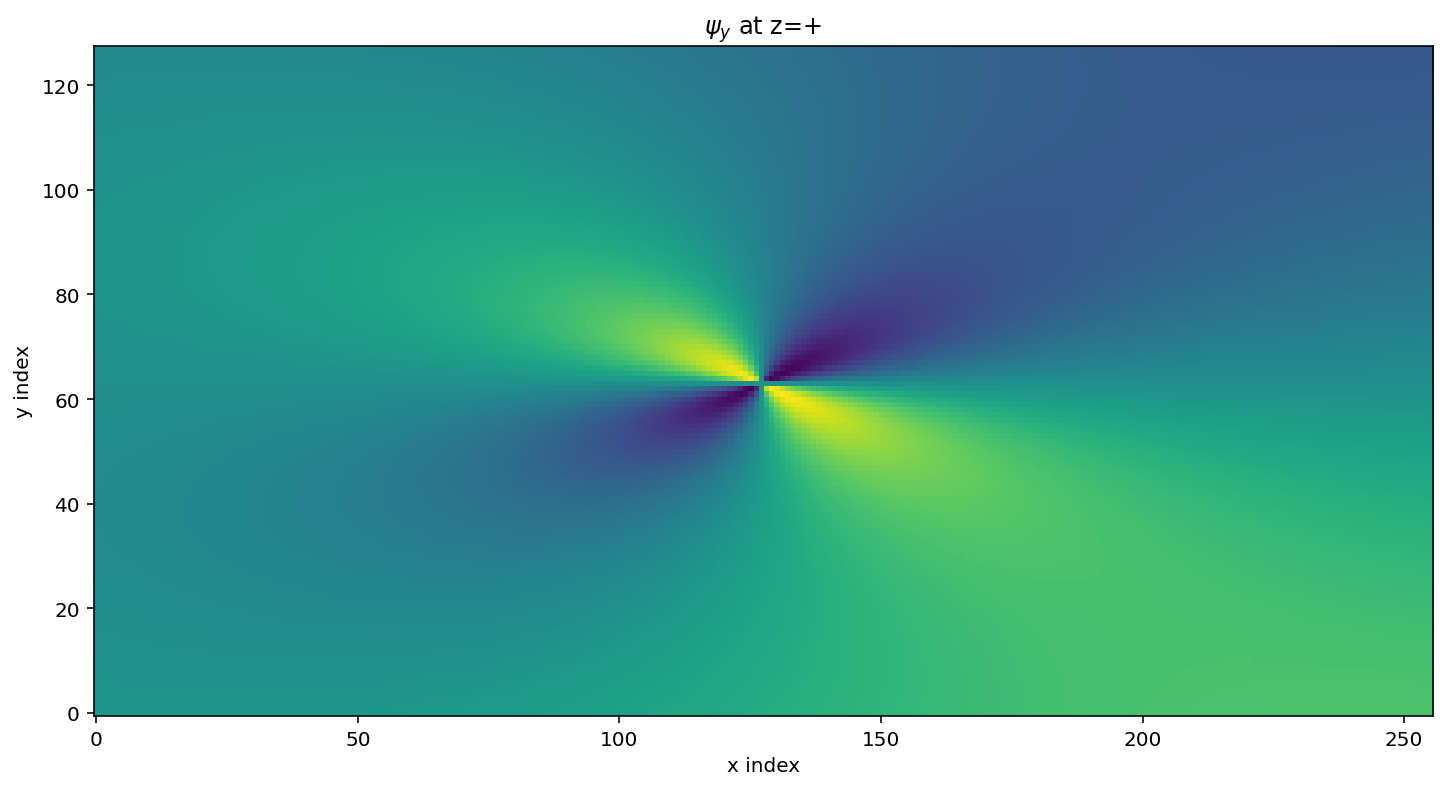

In [49]:
M = Gy[:,:,nz].T

fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(M, origin='lower', aspect='equal')
ax.set_title(r'$\psi_y$ at z=+')
ax.set_xlabel('x index')
ax.set_ylabel('y index')

Text(0.5, 0, 'x')

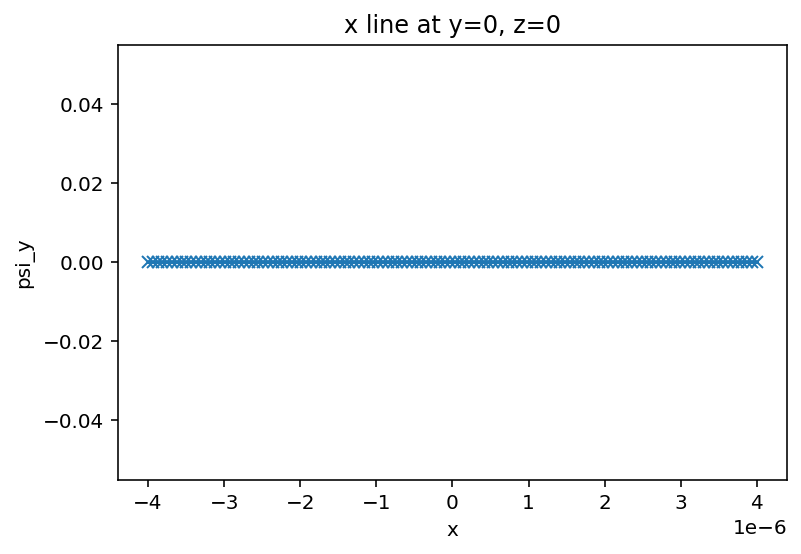

In [50]:
# x line
fig, ax = plt.subplots()
ax.plot(xvec, psi_y(xvec,0,0,beta), label='CSR3D', marker='x')
ax.set_title('x line at y=0, z=0')
ax.set_ylabel('psi_y')
ax.set_xlabel('x')

Text(0.5, 0, 'y')

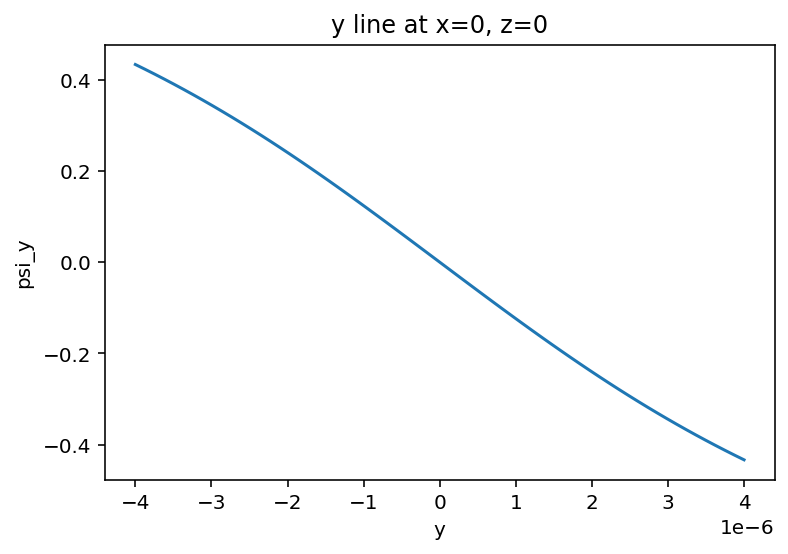

In [51]:
# y line
fig, ax = plt.subplots()
ax.plot(yvec, psi_y(0,yvec,0,beta))
ax.set_title('y line at x=0, z=0')
ax.set_ylabel('psi_y')
ax.set_xlabel('y')

Text(0.5, 0, 'z')

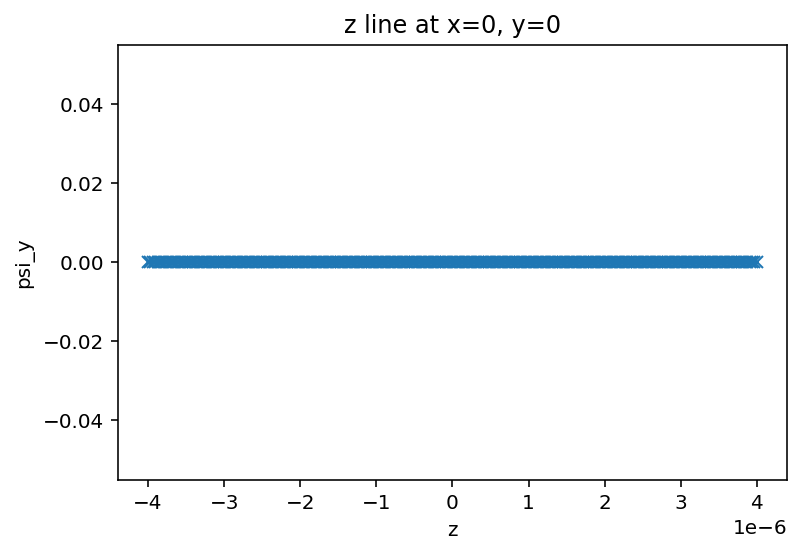

In [52]:
# z line
fig, ax = plt.subplots()
ax.plot(zvec, psi_y0(0,0,zvec,beta,1e-6, 1e-6, 1e-6), marker='x', label='CSR2D')
ax.set_title('z line at x=0, y=0')
ax.set_ylabel('psi_y')
ax.set_xlabel('z')